## 人脸过滤器

现在，使用已训练的人脸关键点检测器，就可以自动执行一些操作了，比如将过滤器添加到人脸。这个notebook是可选的，你可以根据在人眼周围检测到的关键点为图像中检测到的人脸添加太阳镜。打开`images/`目录，看一看我们还为你提供了哪些用于尝试的 .png！

<img src="images/face_filter_ex.png" width=60% height=60%/>

下面，查看一下我们将要使用的太阳镜.png，然后开始行动吧！

In [1]:
# import necessary resources
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

Image shape:  (1123, 3064, 4)


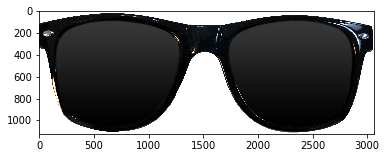

In [2]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

## 第四个维度

你会注意到这个图像实际上有*4 个颜色通道*，与一般的RGB图像不同，因为一般的RGB图像只有3个颜色通道。这是由于我们设置了标记`cv2.IMREAD_UNCHANGED`，这个标记会告诉它使其读取另一个颜色通道。

#### Alpha通道
除了具有通常彩色图像的红色、蓝色和绿色通道，第4个通道表示图像中**每个像素的透明度级别**，这个通道通常被称为**alpha**通道。透明度通道的工作原理如下：像素越低，像素越透明。这里的下限（即完全透明）为零，因此任何设置为0的像素都不会被看到；上图中这些看起来像白色背景像素，但它们实际上是完全透明的。

有了这个透明的通道，我们将这个太阳镜的矩形图像放在一张人脸图像上，仍然可以看到人脸区域在技术上被太阳镜图像的透明背景覆盖了！

接下来，我们看看下一个Python单元格中太阳镜图像的alpha通道。因为图像背景中的许多像素的alpha值为0，所以如果我们想看到它们，就需要显式地输出非零值。

The alpha channel looks like this (black pixels = transparent): 


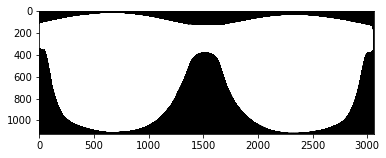

In [3]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [4]:
# just to double check that there are indeed non-zero values
# let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


#### 覆盖图像

覆盖图像的意思是说，当我们将太阳镜图像放在另一个图像上时，我们可以把透明度通道当做一个过滤器：

* 如果像素不透明（即 alpha_channel> 0），则将它们覆盖在新图像上

#### 关键点位置

在这个过程时，了解哪个关键点属于眼睛或嘴巴等，这一点对你很有帮助，因此在下图中我们还直接在图像上输出了每个人脸面部关键点的索引，这样就可以分辨哪些关键点适合眼睛、眉毛等，

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

使用对应于人脸边缘的关键点来定义太阳镜的宽度，并使用眼睛的位置来定义位移，这个方法可能也会很有用。

接下来，我们要加载一个示例图像。你会从下面提供的训练数据集中获得一个图像和一组关键点，但也可以使用自己的CNN模型为*任何*一张人脸图像生成关键点（如在Notebook 3中）并进行相同的覆盖处理！

In [5]:
# load in the data if you have not already!
# otherwise, you may comment out this cell
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: Permission denied
--2020-03-25 12:22:36--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.207.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.207.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
/data: Permission denied
/data/train-test-data.zip: No such file or directory

Cannot write to ‘/data/train-test-data.zip’ (Success).
unzip:  cannot find or open /data/train-test-data.zip, /data/train-test-data.zip.zip or /data/train-test-data.zip.ZIP.


In [6]:
# load in training data
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [7]:
# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


Image name:  Christopher_Walken_01.jpg


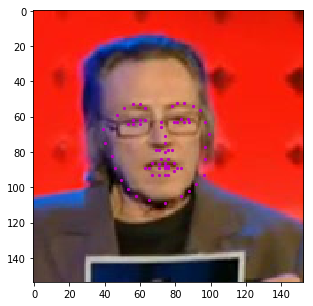

In [8]:
# a selected image
n = 120
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

接下来，你会看到在加载的图像中将太阳镜放在这个人面部的一个示例。

请注意，关键点会在上面的编号图像中逐个编号，因此`key_pts[0,:]`对应于标记图像中的第一个点（1）。

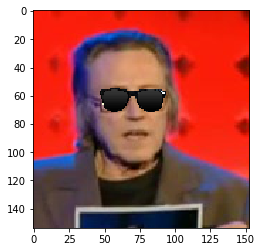

In [9]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(image)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[17, 0])
y = int(key_pts[18, 1])

# height and width of sunglasses
# h = length of nose
h = int(abs(key_pts[27,1] - key_pts[33,1]))
# w = left to right eyebrow edges
w = int(abs(key_pts[17,0] - key_pts[26,0]))

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
# resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color


# display the result!
plt.imshow(image_copy)

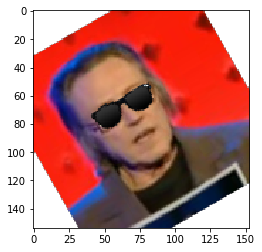

In [10]:
rows,cols,alpha = image_copy.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
dst = cv2.warpAffine(image_copy,M,(cols,rows))
plt.imshow(dst)

#### 接下来的步骤

查看`images/`目录，查看其他可用的覆盖图像.png！此外，你可能会注意到，太阳镜的覆盖层并不完美。因此，我们建议你尝试调整眼镜宽度和高度的比例，并研究如何在OpenCV中执行 [图像旋转](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html)，从而将覆盖层与任何一种人脸表情都能够相匹配。

Image shape:  (480, 960, 4)


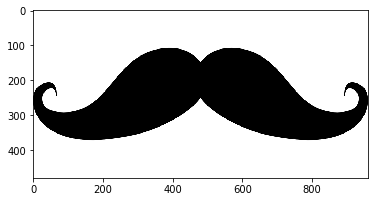

In [11]:
moustache = cv2.imread('images/moustache.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(moustache)

# print out its dimensions
print('Image shape: ', moustache.shape)

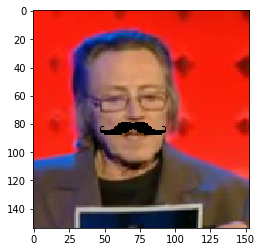

In [20]:
image_copy = np.copy(image)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[17, 0])
y = int(key_pts[1, 1])

# height and width of sunglasses
# h = length of nose
h = int(abs(key_pts[27,1] - key_pts[33,1]))
# w = left to right eyebrow edges
w = int(abs(key_pts[17,0] - key_pts[26,0]))

# read in sunglasses
moustache = cv2.imread('images/moustache.png', cv2.IMREAD_UNCHANGED)
# resize sunglasses
new_moustache =  cv2.resize(moustache, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_moustache[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_moustache[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color


# display the result!
plt.imshow(image_copy)

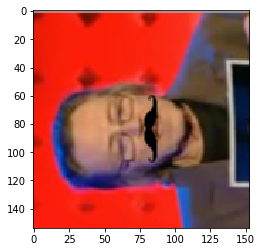

In [21]:
rows,cols,alpha = image_copy.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
dst = cv2.warpAffine(image_copy,M,(cols,rows))
plt.imshow(dst)

Image shape:  (678, 960, 4)


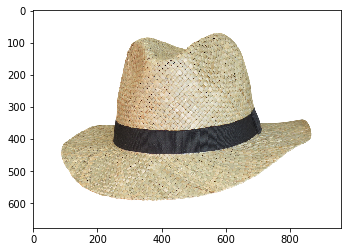

In [14]:
straw_hat = cv2.imread('images/straw_hat.png', cv2.IMREAD_UNCHANGED)
straw_hat = cv2.cvtColor(straw_hat,cv2.COLOR_BGRA2RGBA)
# plot our image
plt.imshow(straw_hat)

# print out its dimensions
print('Image shape: ', straw_hat.shape)

39.0
52.0
(154, 153, 4)
30
58


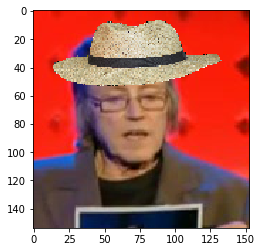

In [54]:
image_copy = np.copy(image)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[0, 0] / key_pts[0, 0])
y = int(key_pts[24, 1] / key_pts[24, 1])
print(key_pts[0, 0])
print(key_pts[24, 1])
print(image_copy.shape)
# height and width of sunglasses
# h = length of nose
h = int(abs(key_pts[27,1] - key_pts[57,1])) 
# w = left to right eyebrow edges
w = int(abs(key_pts[0,0] - key_pts[16,0])) 
print(h)
print(w)
# read in sunglasses
straw_hat = cv2.imread('images/straw_hat.png', cv2.IMREAD_UNCHANGED)
straw_hat = cv2.cvtColor(straw_hat,cv2.COLOR_BGRA2RGBA)
# resize sunglasses
new_straw_hat =  cv2.resize(straw_hat, (int(w * 2.5), int(h * 2)), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+int(h * 2),x:x+int(w * 2.5)]

# find all non-transparent pts
ind = np.argwhere(new_straw_hat[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_straw_hat[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+int(h * 2),x:x+int(w * 2.5)] = roi_color


# display the result!
plt.imshow(image_copy)

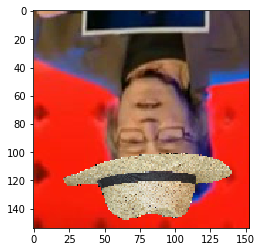

In [55]:
rows,cols,alpha = image_copy.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
dst = cv2.warpAffine(image_copy,M,(cols,rows))
plt.imshow(dst)